# 1 - Create supplementary figure on the 80 steady-state constant climate experiments

- to run the code, you need additional climate data from ISIMIP3b that are available here: https://cluster.klima.uni-bremen.de/~lschuster/isimip3b/isimip3b_tasAdjust_monthly 

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from help_functions import cmap, scaler  # unified colorscale for manuscript and scaler of that colorscale
# path to isimip3b files that are available under https://cluster.klima.uni-bremen.de/~lschuster/isimip3b/: 
# this needs to be changed if not run from the OGGM cluster and the data needs to be downloaded!
path = '/home/www/lschuster/isimip3b/'

In [6]:
exp_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]

scenarios = ['ssp126', 'ssp370', 'ssp585']
# get the global mean average temperatures of the experiments... 
pd_avg_exps= pd.read_csv('../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b.csv', index_col=[0])

In [3]:
pd_global_temp_exp = pd.DataFrame(columns=['gcm', 'period_scenario', 'temp_ch_ipcc'])

typ = 'tasAdjust'
temp_change_l = []
period_scenario_l =[]
gcm_l = []
region_l = []
global_tas_mean_h = {}
global_tas_mean_f = {}
for gcm in gcms:
    if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
        ensemble = 'r1i1p1f1'
    elif gcm == 'ukesm1-0-ll':
        ensemble = 'r1i1p1f2'

    folder_output = 'isimip3b_{}_monthly'.format(typ)

    ybegin = 1850
    yend = 2014
    scenario = 'hist'
    path_output = path + '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble,
                                                                              'historical', typ, ybegin, yend)
    with xr.open_dataset(path_output) as ds_tas_yearly:
        ds_tas_yearly = ds_tas_yearly.groupby('time.year').mean().load()
        # Normal Weight
        #this needs to be the same as the weight!!!
        ds_tas_yearly.coords['lon'] = np.where(ds_tas_yearly.lon.values < 0, ds_tas_yearly.lon.values + 360,
                              ds_tas_yearly.lon.values)
        ds_tas_yearly = ds_tas_yearly.sortby(ds_tas_yearly.lon)
        weight = np.cos(np.deg2rad(ds_tas_yearly.lat.astype(np.float64))).clip(0)
        weight =  ds_tas_yearly.tasAdjust.isel(year=0) * 0. + weight
        weight = weight/weight.sum()
        #ds_tas_yearly['weight'] = (('lat', 'lon'), weight.values / weight.sum().values)
        global_tas_mean = ds_tas_yearly.copy()
        global_tas_mean['tasAdjust'] = (ds_tas_yearly.tasAdjust * weight).sum(dim='lon').sum(dim='lat') - 273.15    # tasAdjust
        ref_period_avg = global_tas_mean.sel(year = slice(str(1986),str(2005))).mean().tasAdjust
        global_tas_mean['delta_GMT'] = global_tas_mean['tasAdjust'] - ref_period_avg + 0.69
        global_tas_mean_h[gcm] = global_tas_mean
        
    for scenario in scenarios:
        ybegin = 2015
        yend = 2100
        path_output_f = path + '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario,
                                                                                        typ, ybegin, yend)

        with xr.open_dataset(path_output_f) as ds_tas_yearly_f:
            ds_tas_yearly_f = ds_tas_yearly_f.groupby('time.year').mean().load()
            # Normal Weight
            #this needs to be the same as the weight!!!
            ds_tas_yearly_f.coords['lon'] = np.where(ds_tas_yearly_f.lon.values < 0, ds_tas_yearly_f.lon.values + 360,
                                  ds_tas_yearly_f.lon.values)
            ds_tas_yearly_f = ds_tas_yearly_f.sortby(ds_tas_yearly_f.lon)
            weight = np.cos(np.deg2rad(ds_tas_yearly_f.lat.astype(np.float64))).clip(0)
            weight =  ds_tas_yearly_f.tasAdjust.isel(year=0) * 0. + weight
            weight = weight/weight.sum()
            global_tas_mean = ds_tas_yearly_f.copy()
            global_tas_mean['tasAdjust'] = (ds_tas_yearly_f.tasAdjust * weight).sum(dim='lon').sum(dim='lat') - 273.15    # tasAdjust
            # need the historical one to actually get the ref. period correction 
            global_tas_mean = xr.concat([global_tas_mean_h[gcm][['tasAdjust']],global_tas_mean[['tasAdjust']]], dim='year')
            ref_period_avg = global_tas_mean.sel(year = slice(str(1986),str(2005))).mean().tasAdjust
            global_tas_mean['delta_GMT'] = global_tas_mean['tasAdjust'] - ref_period_avg + 0.69
            global_tas_mean_f[f'{gcm}_{scenario}'] = global_tas_mean

In [4]:
# get the shuffled year key:
pd_shuffled_yrs = pd.read_csv('../0_experimental_protocol_files/shuffling/shuffled_years_GlacierMIP3.csv', index_col=0)
periods = pd_shuffled_yrs.columns
# template of shuffled climate values (that will be filled afterwards)
periods = pd_shuffled_yrs.columns
simulation_years = pd_shuffled_yrs.index  # from 0 to 4999
pd_empty_clim_template = pd.DataFrame(np.NaN, columns=periods, index=simulation_years)


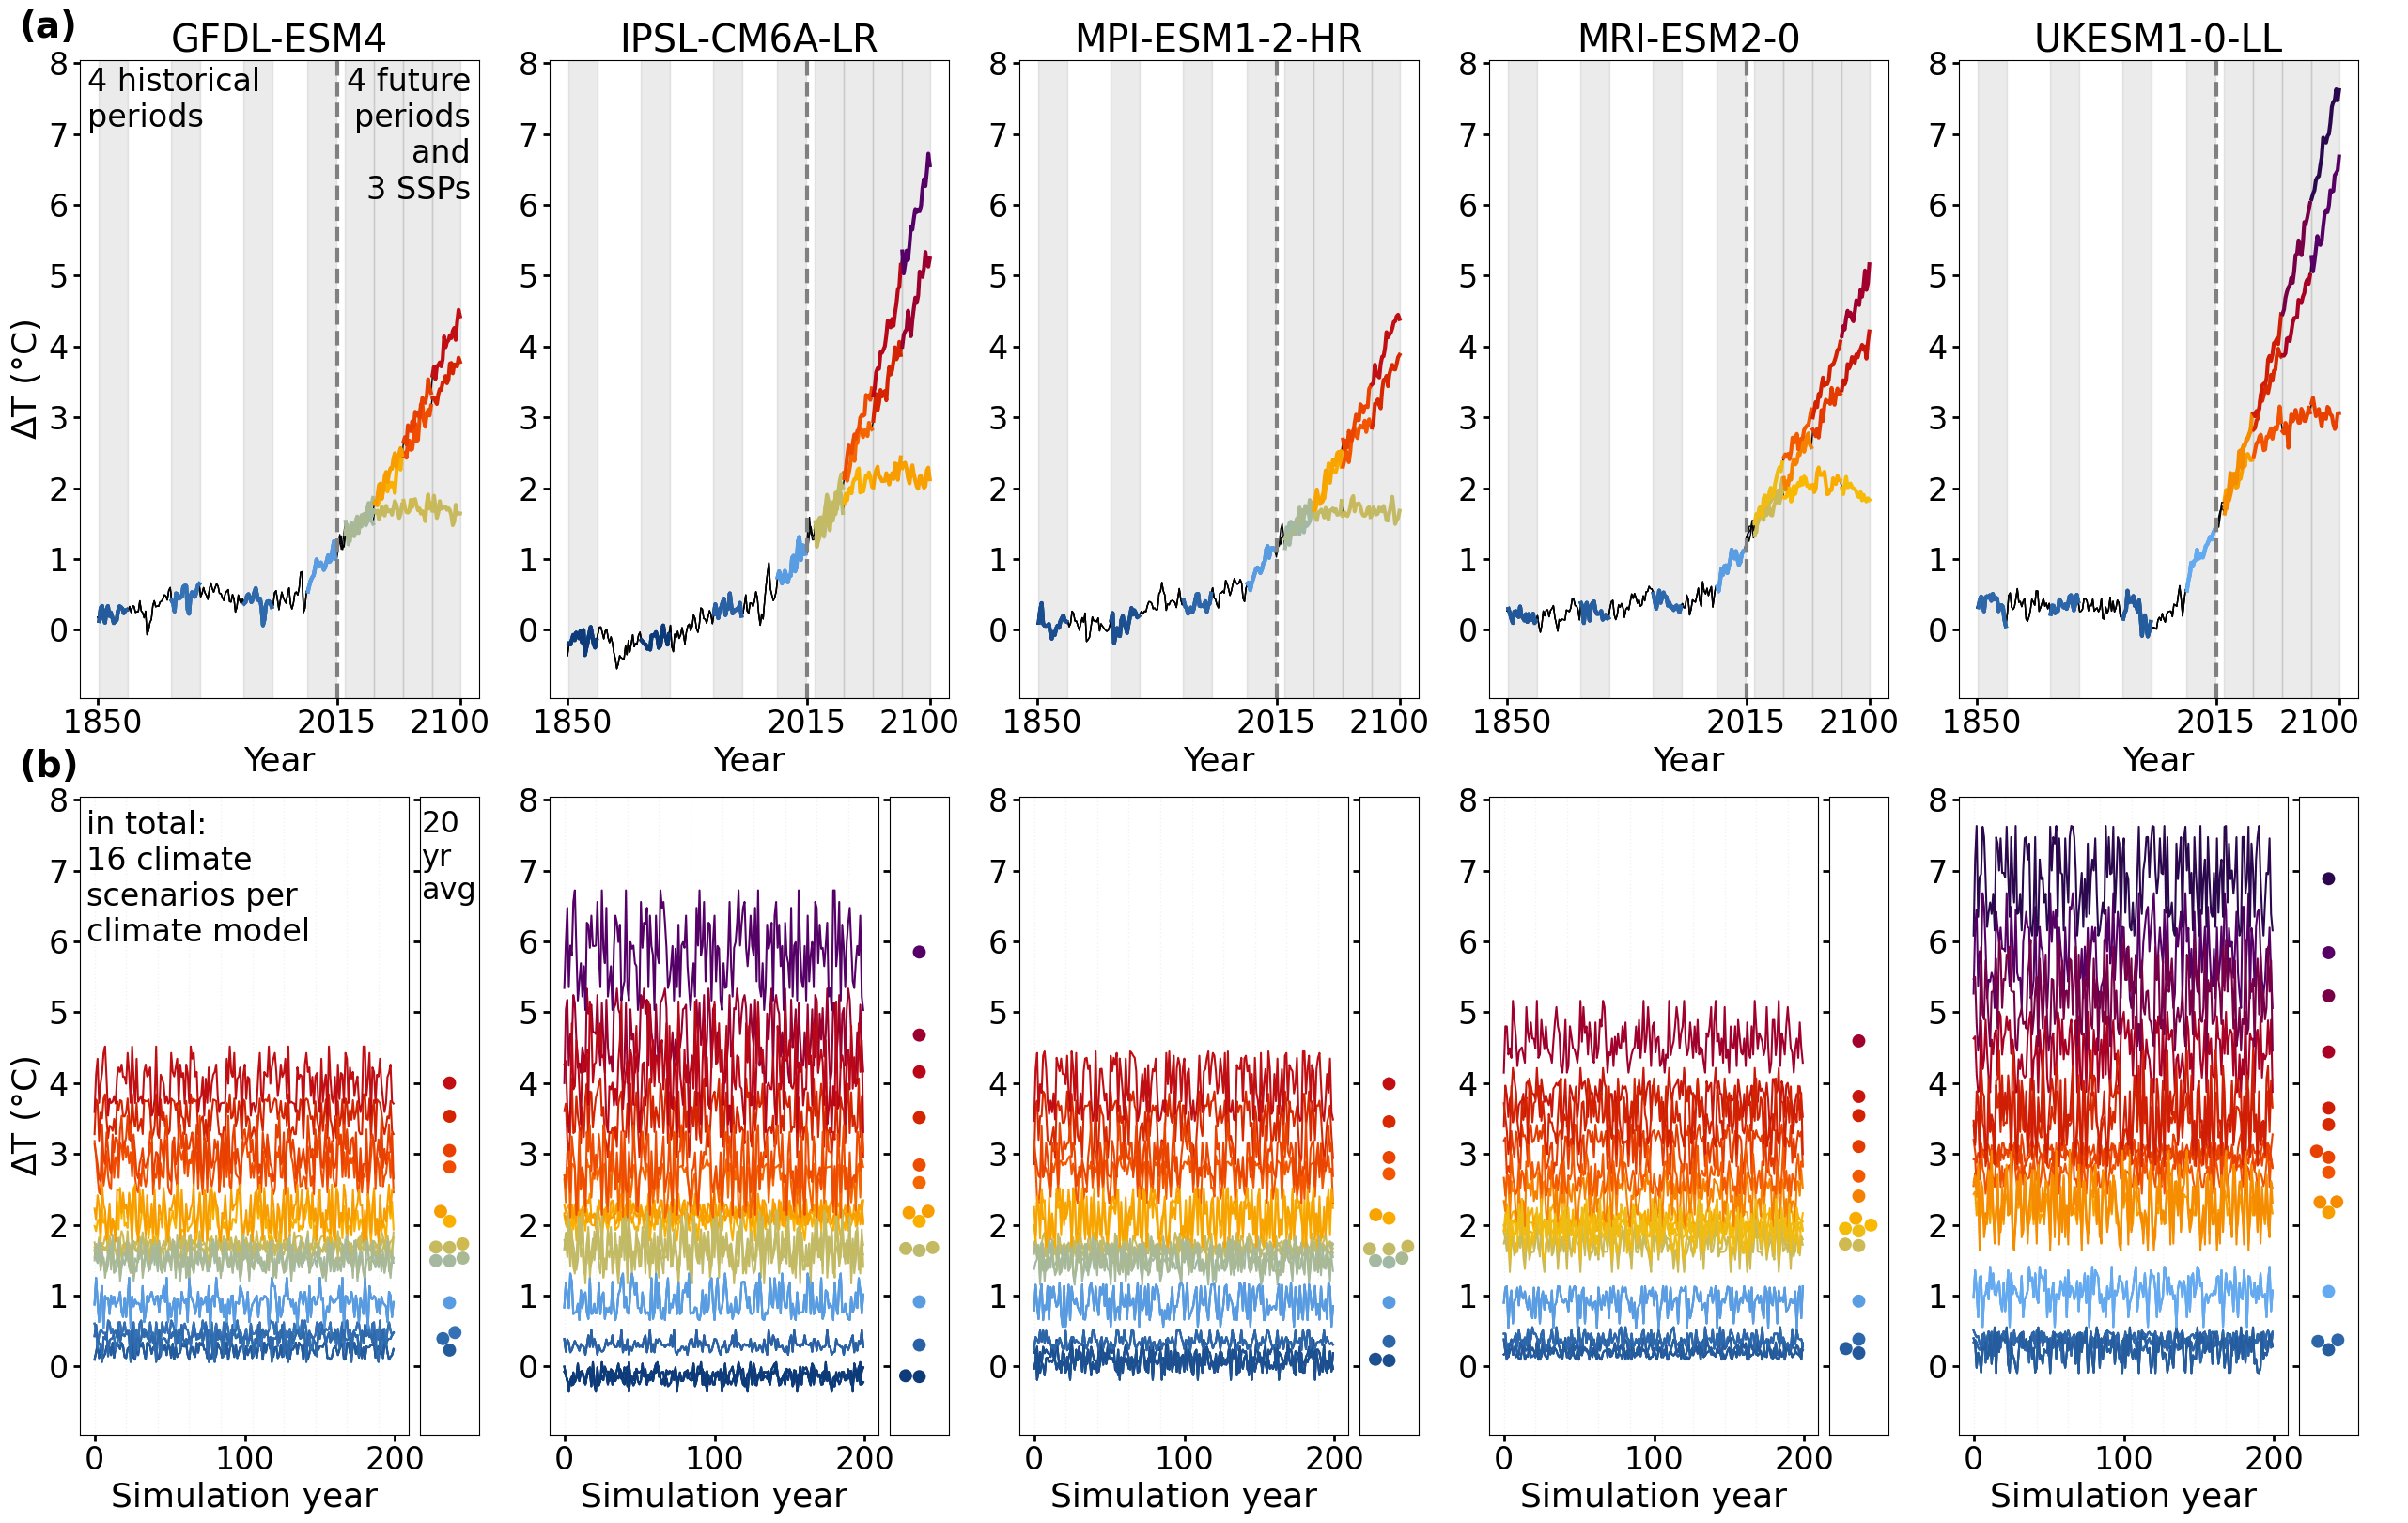

In [7]:
plt.rc('font', size=24)  

# Create a figure object
fig = plt.figure(figsize=(25, 16))
deltax = 0.021
ylim = (-0.9583665739415356, 8.038717637227537)
# Define the position and size of each subplot
yspan=0.424
positions = [
    [0.05-deltax, 0.54, 0.17, yspan],  # First row, first subplot
    [0.25-deltax, 0.54, 0.17, yspan],   # First row, second subplot
    [0.45-deltax, 0.54, 0.17, yspan],  # First row, third subplot
    [0.65-deltax, 0.54, 0.17, yspan],   # First row, fourth subplot
    [0.85-deltax, 0.54, 0.17, yspan],   # First row, fifth subplot

    [0.05-deltax, 0.05, 0.14, yspan],  # Second row, first subplot
    [0.195-deltax, 0.05, 0.025, yspan],  # Second row, first subplot
    [0.25-deltax, 0.05, 0.14, yspan],   # Second row, second subplot
    [0.395-deltax, 0.05, 0.025, yspan],  # Second row, first subplot
    [0.45-deltax, 0.05, 0.14, yspan],  # Second row, third subplot
    [0.595-deltax, 0.05, 0.025, yspan],  # Second row, first subplot
    
    [0.65-deltax, 0.05, 0.14, yspan],  # Second row, third subplot
    [0.795-deltax, 0.05, 0.025, yspan],  # Second row, first subplot
    
    [0.85-deltax, 0.05, 0.14, yspan],   # Second row, fourth subplot
    [0.995-deltax, 0.05, 0.025, yspan],  # Second row, first subplot   
]

# Add subplots using the defined positions
for i in range(15)[:5]:
    ax = fig.add_axes(positions[i])
    
    gcm = gcms[i]
    for scenario in scenarios:
        global_tas_mean = global_tas_mean_f[f'{gcm}_{scenario}']
        ax.set_title(gcm.upper())
        ax.plot(global_tas_mean.year, global_tas_mean.delta_GMT, color='black', alpha = 1, lw=1)
        for exp_time in exp_times:
            exp_period = global_tas_mean.sel(year=slice(str(exp_time), str(exp_time+19)))
            ax.axvspan(exp_time-0.5,exp_time+0.5+19, color='grey', alpha=0.05)
            exp_period_avg = exp_period.mean(dim='year').delta_GMT.values
            c = cmap(scaler.transform(exp_period_avg.reshape(-1,1))).squeeze()
            ax.plot(exp_period.year, exp_period.delta_GMT, color=c, lw=3)
    if i==0:
        ax.set_ylabel(r'$\Delta$T (°C)', fontsize=26)
        ax.text(0.02, 0.99, '4 historical\nperiods',
                horizontalalignment='left',
                verticalalignment='top', transform=ax.transAxes, fontsize=24)
        ax.text(0.98, 0.99, '4 future\nperiods\nand\n3 SSPs',
                horizontalalignment='right',
                verticalalignment='top', transform=ax.transAxes, fontsize = 24)
        ax.text(-0.15, 1.08, '(a)',
                horizontalalignment='left',
                verticalalignment='top', transform=ax.transAxes, fontsize=28, fontweight='bold')
        ax.text(-0.15, -0.08, '(b)',
                    horizontalalignment='left',
                    verticalalignment='top', transform=ax.transAxes, fontsize=28, fontweight='bold')
    ax.set_xlabel('Year', fontsize=26)
    ax.axvline(2015, lw=3, ls='--', color='grey')
    ax.set_ylim(ylim)
    ax.tick_params(axis='both', which='major', width=2, length=5)
    ax.tick_params(axis='both', which='minor', width=1, length=2)
    if i==4:
        ax.set_xticks([1850,2015,2100], labels=[' 1850', '2015', '2100    '])
    else:
        ax.set_xticks([1850,2015,2100], labels=[' 1850', '2015', '2100  '])

    
j_avg = 0
j_shuffle =0
for i in range(15)[5:]:
    ax = fig.add_axes(positions[i])

    if i in [6,8,10,12,14]:
        ax.set_yticklabels(labels='')
        ax.set_xticklabels(labels='')

        gcm = gcms[j_avg]
        pd_avg_exps_gcm = pd_avg_exps.loc[pd_avg_exps.gcm==gcm]
        pd_avg_exps_gcm = pd_avg_exps_gcm.sort_values(by='temp_ch_ipcc')
        colors_l = cmap(scaler.transform(pd_avg_exps_gcm['temp_ch_ipcc'].values.reshape(-1,1))).squeeze()
        sns.swarmplot(ax=ax,data=pd_avg_exps_gcm, y='temp_ch_ipcc', palette=sns.color_palette(colors_l), hue='temp_ch_ipcc',
                      legend=False, size=10) #, cut=0)
        ax.set_ylabel('')
        ax.set_ylim(ylim)
        ax.set_xticks([])  # Remove x-axis ticks
        ax.tick_params(axis='both', which='major', width=2, length=5)
        ax.tick_params(axis='both', which='minor', width=1, length=2)
        if j_avg==0:
             ax.text(0.02, 0.98, '20\nyr\navg',
                     horizontalalignment='left',
                     verticalalignment='top', transform=ax.transAxes, fontsize=23)
        j_avg+=1
    else:
        gcm = gcms[j_shuffle]
        for scenario in scenarios:
            global_tas_mean = global_tas_mean_f[f'{gcm}_{scenario}']
            for exp_time in exp_times:
                exp_period = global_tas_mean.sel(year=slice(str(exp_time), str(exp_time+19)))
                exp_period_avg = exp_period.mean(dim='year').delta_GMT.values
                c = cmap(scaler.transform(exp_period_avg.reshape(-1,1))).squeeze()
                pd_shuffle_clim = pd_empty_clim_template.copy()
                # get the shuffled climate data for each experiment (time period)
                p = f'{str(exp_time)}-{str(exp_time+19)}'
                pd_shuffle_clim[p] = global_tas_mean.delta_GMT.sel(year=pd_shuffled_yrs[p].values).values
                ax.plot(pd_shuffle_clim[p].iloc[:200].index, pd_shuffle_clim[p].iloc[:200].values, color=c) 
        for jj in np.arange(0,200,21):
            ax.axvline(jj,lw=1,color='grey', ls=':', alpha = 0.1)
        if j_shuffle==0:
            ax.text(0.02, 0.98, 'in total:\n16 climate\nscenarios per\nclimate model',
                    horizontalalignment='left',
                    verticalalignment='top', transform=ax.transAxes, fontsize=24)
            ax.set_ylabel(r'$\Delta$T (°C)', fontsize=26)

        ax.set_ylim(ylim)
        ax.set_xlabel('Simulation year', fontsize=26)
        ax.tick_params(axis='both', which='major', width=2, length=5)
        ax.tick_params(axis='both', which='minor', width=1, length=2)
        j_shuffle+=1
        
#plt.tight_layout()
plt.savefig('figures/extended_data/fig_ED_5_climate.png')
plt.savefig('figures/extended_data/fig_ED_5_climate.pdf')

**Same figure as above, but simpler**

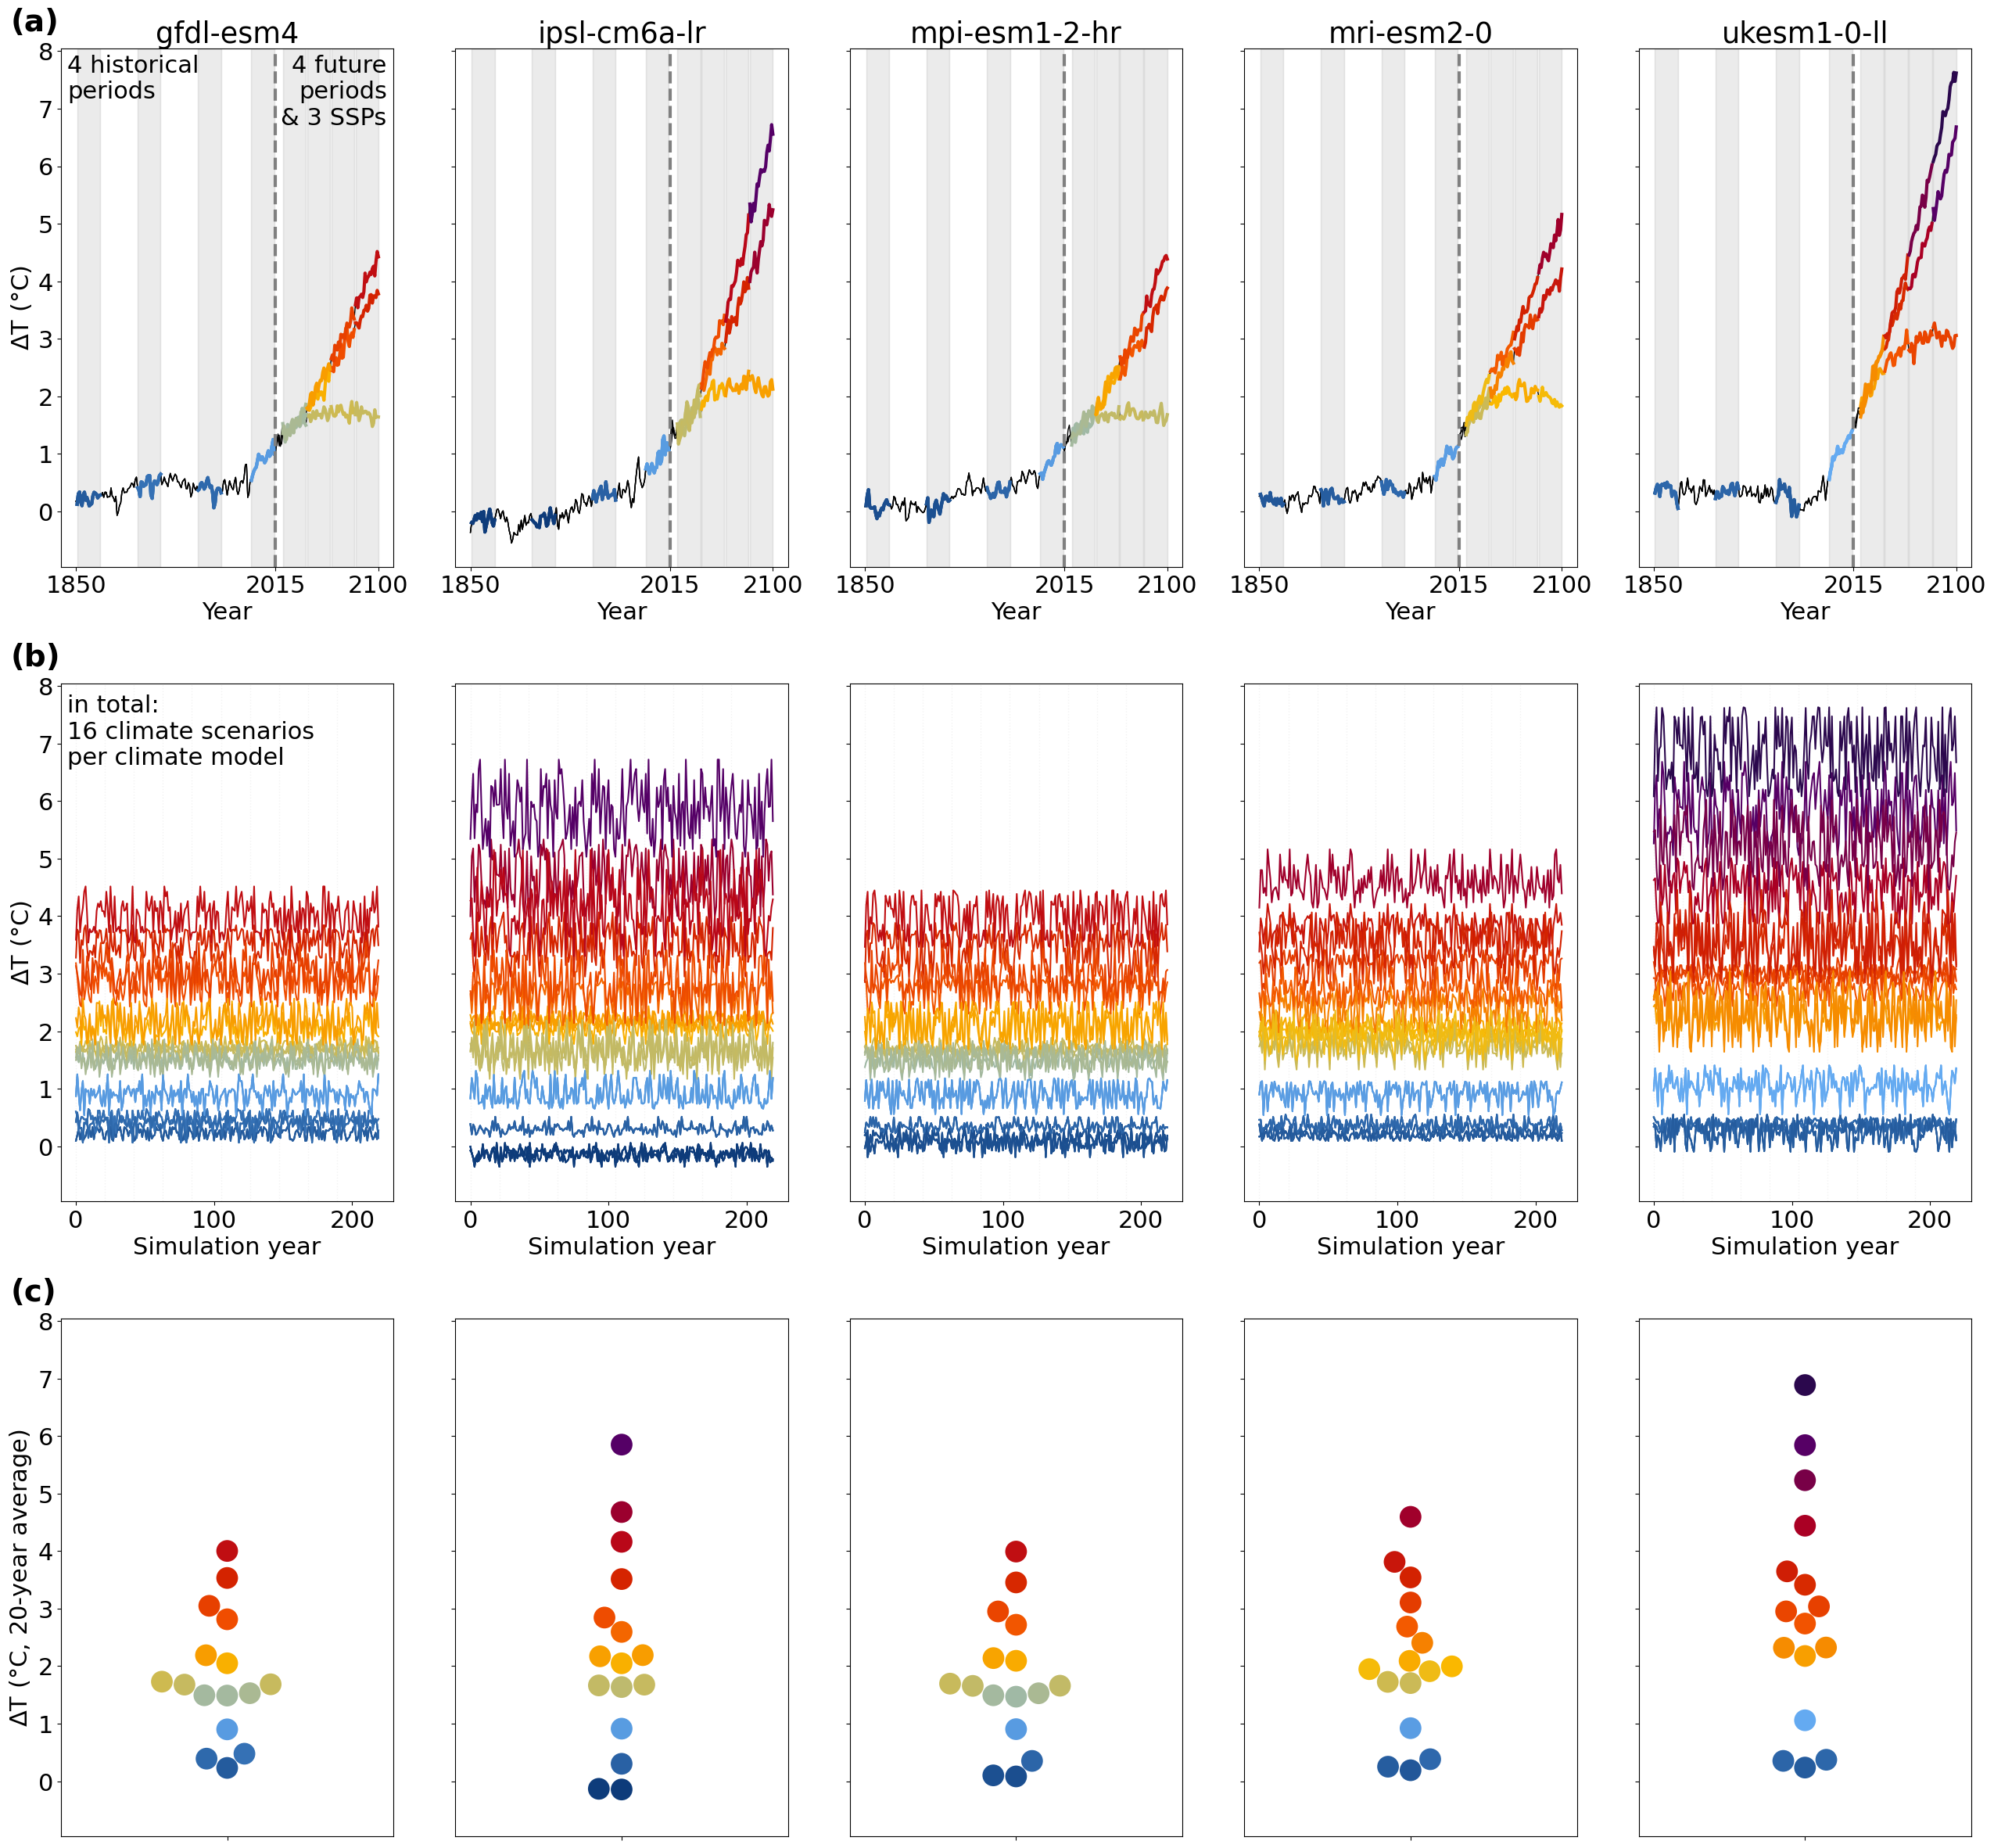

In [8]:
plt.rc('font', size=22)  

fig, axs = plt.subplots(3,5,figsize=(26,24), sharey=True)

for j,gcm in enumerate(gcms):
    ax = axs[0][j]
    for scenario in scenarios:
        global_tas_mean = global_tas_mean_f[f'{gcm}_{scenario}']
        ax.set_title(gcm)
        ax.plot(global_tas_mean.year, global_tas_mean.delta_GMT, color='black', alpha = 1, lw=1)
        for exp_time in exp_times:
            exp_period = global_tas_mean.sel(year=slice(str(exp_time), str(exp_time+19)))
            ax.axvspan(exp_time,exp_time+19, color='grey', alpha=0.05)
            exp_period_avg = exp_period.mean(dim='year').delta_GMT.values
            c = cmap(scaler.transform(exp_period_avg.reshape(-1,1))).squeeze()
            ax.plot(exp_period.year, exp_period.delta_GMT, color=c, lw=3)
    if j==0:
        ax.set_ylabel(r'$\Delta$T (°C)')
        ax.text(0.02, 0.99, '4 historical\nperiods',
                horizontalalignment='left',
                verticalalignment='top', transform=ax.transAxes, fontsize=22)
        ax.text(0.98, 0.99, '4 future\nperiods\n& 3 SSPs',
                horizontalalignment='right',
                verticalalignment='top', transform=ax.transAxes, fontsize = 22)
        ax.text(-0.15, 1.08, '(a)',
                horizontalalignment='left',
                verticalalignment='top', transform=ax.transAxes, fontsize=28, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_xticks([1850,2015,2100])
    ax.axvline(2015, lw=3, ls='--', color='grey')
    # 1900,1950, # 2050,
for j,gcm in enumerate(gcms):
    ax = axs[1][j]
    for scenario in scenarios:
        global_tas_mean = global_tas_mean_f[f'{gcm}_{scenario}']
        for exp_time in exp_times:
            exp_period = global_tas_mean.sel(year=slice(str(exp_time), str(exp_time+19)))
            exp_period_avg = exp_period.mean(dim='year').delta_GMT.values
            c = cmap(scaler.transform(exp_period_avg.reshape(-1,1))).squeeze()
            pd_shuffle_clim = pd_empty_clim_template.copy()
            # get the shuffled climate data for each experiment (time period)
            p = f'{str(exp_time)}-{str(exp_time+19)}'
            pd_shuffle_clim[p] = global_tas_mean.delta_GMT.sel(year=pd_shuffled_yrs[p].values).values
            ax.plot(pd_shuffle_clim[p].iloc[:220].index, pd_shuffle_clim[p].iloc[:220].values, color=c) 
    for jj in np.arange(0,200,21):
        ax.axvline(jj,lw=1,color='grey', ls=':', alpha = 0.1)
    if j==0:
        ax.text(0.02, 0.98, 'in total:\n16 climate scenarios\nper climate model',
                horizontalalignment='left',
                verticalalignment='top', transform=ax.transAxes, fontsize=22)
        ax.set_ylabel(r'$\Delta$T (°C)')
        ax.text(-0.15, 1.08, '(b)',
                horizontalalignment='left',
                verticalalignment='top', transform=ax.transAxes, fontsize=28, fontweight='bold')
    ax.set_xlabel('Simulation year')
        
    ylim = ax.get_ylim()

for j,gcm in enumerate(gcms): 
    ax = axs[2][j]
    pd_avg_exps_gcm = pd_avg_exps.loc[pd_avg_exps.gcm==gcm]
    pd_avg_exps_gcm = pd_avg_exps_gcm.sort_values(by='temp_ch_ipcc')
    colors_l = cmap(scaler.transform(pd_avg_exps_gcm['temp_ch_ipcc'].values.reshape(-1,1))).squeeze()
    #sns.swarmplot(ax=ax, data=pd_avg_exps_gcm, y='temp_ch_ipcc') #, palette=colors_l, hue='temp_ch_ipcc') #, cut=0)
    sns.swarmplot(ax=ax,data=pd_avg_exps_gcm, y='temp_ch_ipcc', palette=sns.color_palette(colors_l), hue='temp_ch_ipcc', legend=False, size=20) #, cut=0)
    ax.set_ylim(ylim)
    if j==0:
        ax.set_ylabel(r'$\Delta$T (°C, 20-year average)')
        ax.text(-0.15, 1.08, '(c)',
                horizontalalignment='left',
                verticalalignment='top', transform=ax.transAxes, fontsize=28, fontweight='bold')

    
plt.tight_layout()
#plt.savefig('figures/fig_ED_XX_climate_simpler.png')